## 1) Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, LeaveOneOut, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


## 2) Muat Dataset EMNIST Letters

=== Load Data EMNIST Letters ===
Dimensi DataFrame: (88799, 785)


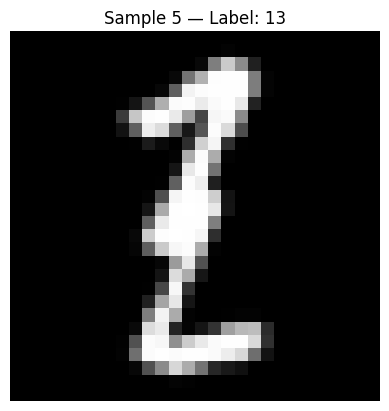

In [22]:
print("=== Load Data EMNIST Letters ===")
emnist = pd.read_csv("emnist-letters-train.csv")
print("Dimensi DataFrame:", emnist.shape)


target = emnist.iloc[:, 0].to_numpy() 
pixels = emnist.iloc[:, 1:].to_numpy().reshape(-1, 28, 28) 


index = 5
plt.imshow(pixels[index], cmap="gray") 
plt.title(f"Sample {index} — Label: {target[index]}")
plt.axis("off")
plt.show()


## 3) Perbaiki Orientasi Gambar
    Citra pada EMNIST sering terbalik secara vertikal dan horizontal. Oleh karena itu perlu diperbaiki dengan rotasi dan flipping.
    

Memperbaiki orientasi gambar EMNIST...


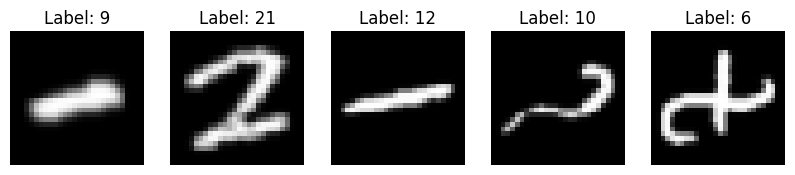

In [19]:
def fix_emnist_orientation(images):
    fixed = []
    for img in images:
        img = np.flipud(np.transpose(img))
        fixed.append(img)
    return np.array(fixed)

print("Memperbaiki orientasi gambar EMNIST...")
X_all = fix_emnist_orientation(X_all)

fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    idx = np.random.randint(0, len(X_all))
    ax.imshow(X_all[idx], cmap='gray')
    ax.set_title(f"Label: {y_all[idx]}")
    ax.axis('off')
plt.show()


## 4) Sampling Seimbang (500 Data per Kelas)

In [35]:
print("Melakukan sampling 500 data per kelas...")

def sample_balanced_data(X, y, per_class=500, seed=42):
    np.random.seed(seed)
    selected_images, selected_labels = [], []
    for label in np.unique(y):
        indices = np.flatnonzero(y == label)
        chosen = np.random.choice(indices, per_class, replace=False)
        selected_images.extend(X[chosen])
        selected_labels.extend(y[chosen])
    return np.stack(selected_images), np.array(selected_labels)

X_sample, y_sample = sample_balanced_data(X_all, y_all) 
print(f"Total data hasil sampling: {len(X_sample)} sampel")


Melakukan sampling 500 data per kelas...
Total data hasil sampling: 13000 sampel


## 5) Ekstraksi Fitur HOG

In [25]:
print("Mengekstraksi fitur HOG...")

start_time = time.time()
X_hog = np.array([
    hog(img, orientations=9, pixels_per_cell=(8, 8),
        cells_per_block=(2, 2), block_norm='L2-Hys', feature_vector=True)
    for img in X_sample
])
end_time = time.time()

print(f"Selesai dalam {round(end_time - start_time, 2)} detik")
print("Dimensi fitur HOG:", X_hog.shape)


Mengekstraksi fitur HOG...
Selesai dalam 6.56 detik
Dimensi fitur HOG: (13000, 144)


## 6) Standarisasi Data

In [28]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_hog)

print("Standarisasi selesai.")
print(f"Rata-rata fitur pertama: {round(X_scaled[:, 0].mean(), 4)}")
print(f"Standar deviasi fitur pertama: {round(X_scaled[:, 0].std(), 4)}")

Standarisasi selesai.
Rata-rata fitur pertama: 0.0
Standar deviasi fitur pertama: 1.0


## 7) Tuning Parameter SVM (Grid Search)
mencari kombinasi parameter terbaik (kernel, C, gamma) yang menghasilkan performa klasifikasi tertinggi terhadap dataset fitur hasil ekstraksi HOG.

In [29]:
print("Proses tuning parameter SVM (Grid Search)...")

param_options = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}


grid = GridSearchCV(SVC(), param_options, cv=5, n_jobs=-1, verbose=2)
grid.fit(X_scaled, y_sample)

best_svm = grid.best_estimator_
print(f"Parameter terbaik: {grid.best_params_}")

Proses tuning parameter SVM (Grid Search)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Parameter terbaik: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


## 8) Evaluasi dengan LOOCV (Subset 13.000 Data)

In [31]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import time

print("\n=== Evaluasi model dengan LOOCV (subset 13.000 data) ===")

#memilih subset yang akan dievaluasi.
X_small = X_scaled[:13000]
y_small = y_sample[:13000]

loo = LeaveOneOut()
y_pred = np.zeros_like(y_small)

print("Mulai proses LOOCV... (ini bisa memakan waktu lama)")
start = time.time()

for i, (train_index, test_index) in enumerate(tqdm(loo.split(X_small), total=len(X_small))):
    model = best_svm.fit(X_small[train_index], y_small[train_index])
    y_pred[test_index] = model.predict(X_small[test_index])

end = time.time()
print(f"Proses selesai dalam {round((end - start)/60, 2)} menit")

print("\n=== Hasil Evaluasi ===")
print(classification_report(y_small, y_pred, digits=4)

acc = accuracy_score(y_small, y_pred)
print(f"Akurasi total: {round(acc * 100, 2)} %")



=== Evaluasi model dengan LOOCV (subset 13.000 data) ===
🚀 Mulai proses LOOCV... (ini bisa memakan waktu lama)


100%|██████████████████████████████████| 13000/13000 [15:56:58<00:00,  4.42s/it]

⏱️ Proses selesai dalam 956.97 menit

=== Hasil Evaluasi ===
              precision    recall  f1-score   support

           1     0.7659    0.8180    0.7911       500
           2     0.8353    0.8620    0.8484       500
           3     0.8887    0.8780    0.8833       500
           4     0.8760    0.9040    0.8898       500
           5     0.8397    0.8800    0.8594       500
           6     0.8805    0.8840    0.8822       500
           7     0.7101    0.6860    0.6979       500
           8     0.8720    0.8720    0.8720       500
           9     0.6908    0.6880    0.6894       500
          10     0.9070    0.8780    0.8923       500
          11     0.9466    0.9220    0.9341       500
          12     0.6925    0.7160    0.7040       500
          13     0.9344    0.9400    0.9372       500
          14     0.8703    0.8860    0.8781       500
          15     0.9287    0.9380    0.9333       500
          16     0.9486    0.9220    0.9351       500
          17     0.7

## 9) Visualisasi Confusion Matrix

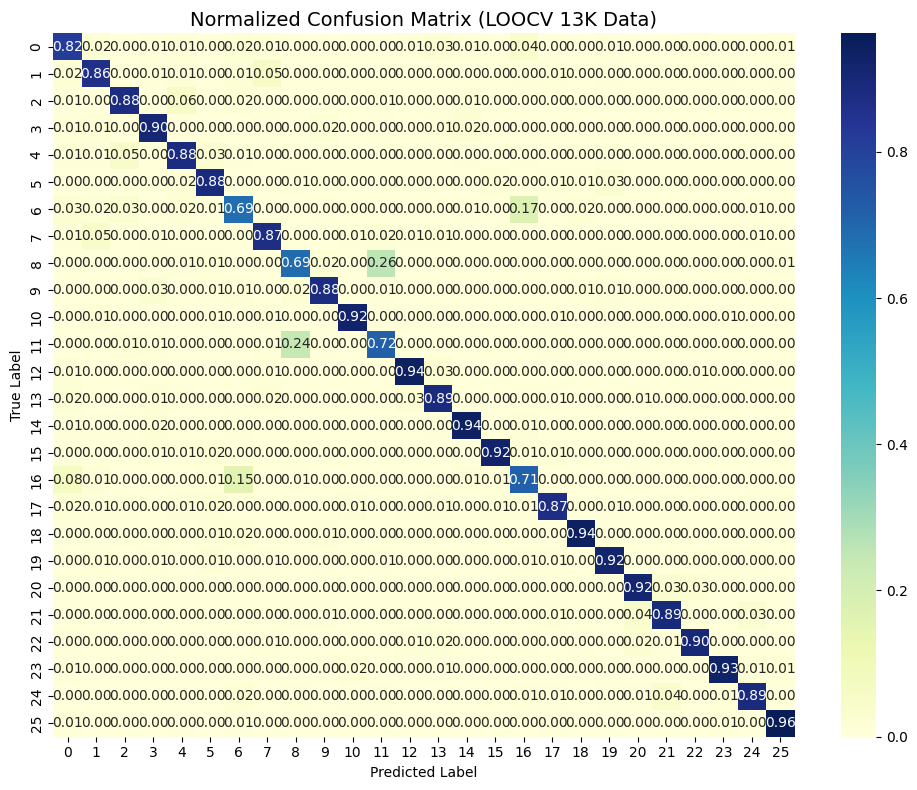

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_small, y_pred, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt=".2f", cbar=True)
plt.title("Normalized Confusion Matrix (LOOCV 13K Data)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


## 10) Simpan Model dan Hasil

In [34]:
start_time = time.time()
print("\nMenyimpan model dan hasil evaluasi...")

joblib.dump(best_svm, 'svm_emnist_model_1.joblib')
joblib.dump(scaler, 'hog_scaler_1.joblib')
np.save('confusion_matrix.npy', cm)

elapsed = round(time.time() - start_time, 2)
print(f"Semua file tersimpan! (Waktu: {elapsed} detik)")



Menyimpan model dan hasil evaluasi...
Semua file tersimpan! (Waktu: 0.01 detik)
